In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim, rot_ksamp
from hyppo.tools import SIMULATIONS
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

import sys
import os
import multiprocessing as mp
from proglearn import UncertaintyForest
from joblib import Parallel, delayed
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
%load_ext autoreload
%autoreload 2

In [2]:
class TestStat:
    def __init__(self, uf, oob_func, n_jobs=1):
        self.uf = uf
        self.oob_func = oob_func
        self.n_jobs = n_jobs
        
    def __call__(self, X, y):
        if not hasattr(self, "leaf_indices_"):
            self.leaf_indices_ = []
            for tree, voter_indices in zip(self.uf.transformers_, self.uf.voter_indices_):
                self.leaf_indices_.append(tree.apply(X[voter_indices]))

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        H_YX = self._refit_apply_oob(X, y)
        return H_Y - H_YX

    def _refit_apply_oob(self, X, y):
        posteriors = np.zeros((X.shape[0], self.uf.n_classes_), dtype=np.float64)
        # posteriors = np.zeros((X.shape[0], self.uf.n_estimators, self.uf.n_classes_), dtype=np.float64)

        for tree, leaf_indices, voter_indices in zip(self.uf.transformers_, self.leaf_indices_, self.uf.voter_indices_):
        # for tree_idx, (leaf_indices, voter_indices) in enumerate(zip(self.leaf_indices_, self.uf.voter_indices_)):
            tree.tree_.value[:, :, :] = 0

            for leaf_id, yval in zip(leaf_indices, y[voter_indices]):
                tree.tree_.value[leaf_id][0, yval] += 1
                # posteriors[leaf_id,]

            proba = tree.tree_.value[leaf_indices][:, 0, :]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0 # solves divide by 0 error
            proba /= normalizer
            posteriors[voter_indices] += proba

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.uf.empirical_prior_

        return np.mean(self.oob_func(posteriors))


In [3]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 100

In [4]:
def _perm_stat(calc_stat, x, y):
    permy = np.random.permutation(y)
    perm_stat = calc_stat(x, permy)

    return perm_stat


def perm_test(calc_stat, X, y, reps=1000, workers=1):
    """
    Calculate the p-value via permutation
    """
    # calculate observed test statistic
    stat = calc_stat(X, y)
    
    null_dist = np.asarray([_perm_stat(calc_stat, X, y) for rep in range(reps)])
    pvalue = ((null_dist >= stat).sum() + 1) / (reps + 1)


    return stat, pvalue

In [5]:
def estimate_power(sim, test):
    
    est_power = []
    for i in tqdm(SAMP_SIZES):
        print("sample size" + str(i))
        print(sim)
    
        pvalues = []
        for _ in tqdm(range(POWER_REPS)): 
            x, y = rot_ksamp(sim, n=i, p=3, noise=True)
            X, y = k_sample_transform([x, y])
            y = y.astype(int)
            y = y.ravel()
            print(X.shape)
            print(y.shape)
            uf = UncertaintyForest(
                n_estimators=100,
                tree_construction_proportion=0.5,
                kappa=np.inf,
                honest_prior="ignore",
                max_features=1.0,
                n_jobs=-2,
            )
            uf = uf.fit(X, y)
            print('Fitted')

            ce = lambda x: entropy(x, axis=1, base=np.exp(1))
            obs_stat = TestStat(uf, ce)

            reps = 100
            stat, pvalue = perm_test(obs_stat, X, y, reps=reps, workers=-2)
            print(pvalue)
            pvalues.append(pvalue)
            with open("./type_vs_attributes_test.csv", "w") as f:
                f.write(f"Test Statistic,p-value\n{stat},{pvalue}")
        num = 0
        for pval in pvalues: 
            if pval <= 0.05: 
                num += 1
        empirical_power = (1+num) / (1+POWER_REPS)
        est_power.append(empirical_power)
        
    print(est_power)
        
    
    print(sim + " done")
    np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}4_20_HonestSampling_100_estimators_100_reps.csv'.format(sim, "UF"),
            est_power, delimiter=',')
    
    return est_power

In [ ]:
for sim_name in tqdm(SIMULATIONS.keys()): 
    power = estimate_power(sim_name, "UF")

In [20]:
power = estimate_power('multimodal_independence', 'UF')

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

sample size5
multimodal_independence
(10, 6)
(10,)
Fitted



  1%|▊                                                                                 | 1/100 [00:01<02:43,  1.65s/it]

0.6732673267326733
(10, 6)
(10,)
Fitted



  2%|█▋                                                                                | 2/100 [00:03<02:56,  1.81s/it]

0.24752475247524752
(10, 6)
(10,)
Fitted



  3%|██▍                                                                               | 3/100 [00:05<02:49,  1.75s/it]

0.4158415841584158
(10, 6)
(10,)
Fitted



  4%|███▎                                                                              | 4/100 [00:06<02:41,  1.68s/it]

0.9702970297029703
(10, 6)
(10,)
Fitted



  5%|████                                                                              | 5/100 [00:08<02:35,  1.64s/it]

0.7326732673267327
(10, 6)
(10,)
Fitted



  6%|████▉                                                                             | 6/100 [00:10<02:30,  1.60s/it]

0.9108910891089109
(10, 6)
(10,)
Fitted



  7%|█████▋                                                                            | 7/100 [00:11<02:27,  1.59s/it]

0.21782178217821782
(10, 6)
(10,)
Fitted



  8%|██████▌                                                                           | 8/100 [00:13<02:24,  1.57s/it]

0.2871287128712871
(10, 6)
(10,)
Fitted



  9%|███████▍                                                                          | 9/100 [00:14<02:20,  1.55s/it]

0.5742574257425742
(10, 6)
(10,)
Fitted



 10%|████████                                                                         | 10/100 [00:16<02:17,  1.53s/it]

0.3465346534653465
(10, 6)
(10,)
Fitted



 11%|████████▉                                                                        | 11/100 [00:17<02:19,  1.57s/it]

0.36633663366336633
(10, 6)
(10,)
Fitted



 12%|█████████▋                                                                       | 12/100 [00:19<02:17,  1.56s/it]

0.019801980198019802
(10, 6)
(10,)
Fitted



 13%|██████████▌                                                                      | 13/100 [00:20<02:16,  1.56s/it]

0.18811881188118812
(10, 6)
(10,)
Fitted



 14%|███████████▎                                                                     | 14/100 [00:22<02:11,  1.52s/it]

0.9603960396039604
(10, 6)
(10,)
Fitted



 15%|████████████▏                                                                    | 15/100 [00:23<02:08,  1.51s/it]

0.5346534653465347
(10, 6)
(10,)
Fitted



 16%|████████████▉                                                                    | 16/100 [00:25<02:06,  1.50s/it]

0.7623762376237624
(10, 6)
(10,)
Fitted



 17%|█████████████▊                                                                   | 17/100 [00:26<02:04,  1.50s/it]

0.04950495049504951
(10, 6)
(10,)
Fitted



 18%|██████████████▌                                                                  | 18/100 [00:28<02:09,  1.57s/it]

0.09900990099009901
(10, 6)
(10,)
Fitted



 19%|███████████████▍                                                                 | 19/100 [00:30<02:08,  1.58s/it]

0.48514851485148514
(10, 6)
(10,)
Fitted



 20%|████████████████▏                                                                | 20/100 [00:31<02:06,  1.58s/it]

0.9504950495049505
(10, 6)
(10,)
Fitted



 21%|█████████████████                                                                | 21/100 [00:33<02:03,  1.57s/it]

0.45544554455445546
(10, 6)
(10,)
Fitted



 22%|█████████████████▊                                                               | 22/100 [00:34<02:00,  1.54s/it]

0.04950495049504951
(10, 6)
(10,)
Fitted



 23%|██████████████████▋                                                              | 23/100 [00:36<01:57,  1.52s/it]

0.7821782178217822
(10, 6)
(10,)
Fitted



 24%|███████████████████▍                                                             | 24/100 [00:37<02:02,  1.61s/it]

0.38613861386138615
(10, 6)
(10,)
Fitted



 25%|████████████████████▎                                                            | 25/100 [00:39<02:01,  1.62s/it]

0.594059405940594
(10, 6)
(10,)
Fitted



 26%|█████████████████████                                                            | 26/100 [00:41<01:56,  1.57s/it]

0.19801980198019803
(10, 6)
(10,)
Fitted



 27%|█████████████████████▊                                                           | 27/100 [00:42<01:53,  1.56s/it]

0.32673267326732675
(10, 6)
(10,)
Fitted



 28%|██████████████████████▋                                                          | 28/100 [00:44<01:50,  1.54s/it]

0.49504950495049505
(10, 6)
(10,)
Fitted



 29%|███████████████████████▍                                                         | 29/100 [00:45<01:49,  1.54s/it]

0.09900990099009901
(10, 6)
(10,)
Fitted



 30%|████████████████████████▎                                                        | 30/100 [00:47<01:46,  1.53s/it]

0.5841584158415841
(10, 6)
(10,)
Fitted



 31%|█████████████████████████                                                        | 31/100 [00:48<01:49,  1.58s/it]

0.9504950495049505
(10, 6)
(10,)
Fitted



 32%|█████████████████████████▉                                                       | 32/100 [00:50<01:47,  1.58s/it]

0.0891089108910891
(10, 6)
(10,)
Fitted



 33%|██████████████████████████▋                                                      | 33/100 [00:52<01:46,  1.59s/it]

0.38613861386138615
(10, 6)
(10,)
Fitted



 34%|███████████████████████████▌                                                     | 34/100 [00:53<01:45,  1.61s/it]

0.8613861386138614
(10, 6)
(10,)
Fitted



 35%|████████████████████████████▎                                                    | 35/100 [00:55<01:41,  1.57s/it]

0.9306930693069307
(10, 6)
(10,)
Fitted



 36%|█████████████████████████████▏                                                   | 36/100 [00:56<01:38,  1.54s/it]

0.8811881188118812
(10, 6)
(10,)
Fitted



 37%|█████████████████████████████▉                                                   | 37/100 [00:58<01:36,  1.53s/it]

0.7920792079207921
(10, 6)
(10,)
Fitted



 38%|██████████████████████████████▊                                                  | 38/100 [00:59<01:34,  1.52s/it]

0.09900990099009901
(10, 6)
(10,)
Fitted



 39%|███████████████████████████████▌                                                 | 39/100 [01:01<01:39,  1.63s/it]

0.297029702970297
(10, 6)
(10,)
Fitted



 40%|████████████████████████████████▍                                                | 40/100 [01:03<01:42,  1.71s/it]

0.7524752475247525
(10, 6)
(10,)
Fitted



 41%|█████████████████████████████████▏                                               | 41/100 [01:04<01:36,  1.63s/it]

0.1485148514851485
(10, 6)
(10,)
Fitted



 42%|██████████████████████████████████                                               | 42/100 [01:06<01:32,  1.60s/it]

0.0594059405940594
(10, 6)
(10,)
Fitted



 43%|██████████████████████████████████▊                                              | 43/100 [01:08<01:33,  1.65s/it]

0.1485148514851485
(10, 6)
(10,)
Fitted



 44%|███████████████████████████████████▋                                             | 44/100 [01:09<01:29,  1.60s/it]

0.0297029702970297
(10, 6)
(10,)
Fitted



 45%|████████████████████████████████████▍                                            | 45/100 [01:11<01:25,  1.55s/it]

0.0297029702970297
(10, 6)
(10,)
Fitted



 46%|█████████████████████████████████████▎                                           | 46/100 [01:12<01:23,  1.54s/it]

0.24752475247524752
(10, 6)
(10,)
Fitted



 47%|██████████████████████████████████████                                           | 47/100 [01:14<01:21,  1.54s/it]

0.07920792079207921
(10, 6)
(10,)
Fitted



 48%|██████████████████████████████████████▉                                          | 48/100 [01:15<01:19,  1.53s/it]

0.42574257425742573
(10, 6)
(10,)
Fitted



 49%|███████████████████████████████████████▋                                         | 49/100 [01:17<01:16,  1.51s/it]

0.0297029702970297
(10, 6)
(10,)
Fitted



 50%|████████████████████████████████████████▌                                        | 50/100 [01:18<01:14,  1.49s/it]

0.25742574257425743
(10, 6)
(10,)
Fitted



 51%|█████████████████████████████████████████▎                                       | 51/100 [01:20<01:12,  1.49s/it]

0.5841584158415841
(10, 6)
(10,)
Fitted



 52%|██████████████████████████████████████████                                       | 52/100 [01:21<01:11,  1.49s/it]

0.900990099009901
(10, 6)
(10,)
Fitted



 53%|██████████████████████████████████████████▉                                      | 53/100 [01:23<01:12,  1.55s/it]

0.6138613861386139
(10, 6)
(10,)
Fitted



 54%|███████████████████████████████████████████▋                                     | 54/100 [01:25<01:18,  1.71s/it]

0.039603960396039604
(10, 6)
(10,)
Fitted



 55%|████████████████████████████████████████████▌                                    | 55/100 [01:26<01:13,  1.63s/it]

0.25742574257425743
(10, 6)
(10,)
Fitted



 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:28<01:10,  1.60s/it]

0.2079207920792079
(10, 6)
(10,)
Fitted



 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:29<01:07,  1.57s/it]

0.6336633663366337
(10, 6)
(10,)
Fitted



 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:31<01:08,  1.62s/it]

0.6534653465346535
(10, 6)
(10,)
Fitted



 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:32<01:04,  1.57s/it]

0.8514851485148515
(10, 6)
(10,)
Fitted



 60%|████████████████████████████████████████████████▌                                | 60/100 [01:34<01:02,  1.56s/it]

0.37623762376237624
(10, 6)
(10,)
Fitted



 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:35<00:59,  1.53s/it]

0.13861386138613863
(10, 6)
(10,)
Fitted



 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:37<00:56,  1.49s/it]

0.18811881188118812
(10, 6)
(10,)
Fitted



 63%|███████████████████████████████████████████████████                              | 63/100 [01:38<00:54,  1.48s/it]

0.8118811881188119
(10, 6)
(10,)
Fitted



 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:40<00:53,  1.50s/it]

0.42574257425742573
(10, 6)
(10,)
Fitted



 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:42<00:55,  1.59s/it]

0.594059405940594
(10, 6)
(10,)
Fitted



 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:43<00:52,  1.55s/it]

0.48514851485148514
(10, 6)
(10,)
Fitted



 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:44<00:49,  1.51s/it]

0.7920792079207921
(10, 6)
(10,)
Fitted



 68%|███████████████████████████████████████████████████████                          | 68/100 [01:46<00:48,  1.51s/it]

0.6237623762376238
(10, 6)
(10,)
Fitted



 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:47<00:46,  1.50s/it]

0.22772277227722773
(10, 6)
(10,)
Fitted



 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:49<00:45,  1.52s/it]

0.26732673267326734
(10, 6)
(10,)
Fitted



 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:51<00:43,  1.50s/it]

0.3465346534653465
(10, 6)
(10,)
Fitted



 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:52<00:42,  1.50s/it]

0.10891089108910891
(10, 6)
(10,)
Fitted



 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:53<00:40,  1.48s/it]

0.8910891089108911
(10, 6)
(10,)
Fitted



 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:56<00:47,  1.81s/it]

0.009900990099009901
(10, 6)
(10,)
Fitted



 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [02:00<01:04,  2.59s/it]

0.39603960396039606
(10, 6)
(10,)
Fitted



 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [02:05<01:13,  3.06s/it]

0.019801980198019802
(10, 6)
(10,)
Fitted



 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [02:08<01:14,  3.25s/it]

0.32673267326732675
(10, 6)
(10,)
Fitted



 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [02:11<01:05,  2.99s/it]

0.5742574257425742
(10, 6)
(10,)
Fitted



 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [02:13<00:57,  2.75s/it]

0.6633663366336634
(10, 6)
(10,)
Fitted



 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [02:16<00:56,  2.83s/it]

0.8910891089108911
(10, 6)
(10,)
Fitted



 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [02:18<00:48,  2.53s/it]

0.6633663366336634
(10, 6)
(10,)
Fitted



 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [02:20<00:44,  2.49s/it]

0.5247524752475248
(10, 6)
(10,)
Fitted



 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [02:22<00:39,  2.32s/it]

0.15841584158415842
(10, 6)
(10,)
Fitted



 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:23<00:32,  2.05s/it]

0.594059405940594
(10, 6)
(10,)
Fitted



 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:25<00:28,  1.89s/it]

0.693069306930693
(10, 6)
(10,)
Fitted



 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [02:27<00:26,  1.86s/it]

0.9702970297029703
(10, 6)
(10,)
Fitted



 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [02:28<00:22,  1.72s/it]

0.900990099009901
(10, 6)
(10,)
Fitted



 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [02:30<00:19,  1.63s/it]

0.44554455445544555
(10, 6)
(10,)
Fitted



 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [02:31<00:17,  1.57s/it]

0.9900990099009901
(10, 6)
(10,)
Fitted



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [02:32<00:15,  1.53s/it]

0.009900990099009901
(10, 6)
(10,)
Fitted



 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [02:34<00:13,  1.50s/it]

0.6138613861386139
(10, 6)
(10,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [02:35<00:12,  1.51s/it]

0.7722772277227723
(10, 6)
(10,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:37<00:10,  1.49s/it]

0.8712871287128713
(10, 6)
(10,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [02:38<00:09,  1.53s/it]

0.7722772277227723
(10, 6)
(10,)
Fitted



 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:42<00:10,  2.02s/it]

0.6138613861386139
(10, 6)
(10,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [02:45<00:09,  2.40s/it]

0.019801980198019802
(10, 6)
(10,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:50<00:09,  3.08s/it]

1.0
(10, 6)
(10,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [02:54<00:06,  3.44s/it]

0.1485148514851485
(10, 6)
(10,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:59<00:04,  4.07s/it]

0.26732673267326734
(10, 6)
(10,)
Fitted



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.297029702970297
sample size24
multimodal_independence
(48, 6)
(48,)
Fitted



  1%|▊                                                                                 | 1/100 [00:04<07:10,  4.35s/it]

0.8811881188118812
(48, 6)
(48,)
Fitted



  2%|█▋                                                                                | 2/100 [00:11<08:15,  5.06s/it]

0.3564356435643564
(48, 6)
(48,)
Fitted



  3%|██▍                                                                               | 3/100 [00:16<08:35,  5.32s/it]

0.26732673267326734
(48, 6)
(48,)
Fitted



  4%|███▎                                                                              | 4/100 [00:21<08:01,  5.02s/it]

0.0297029702970297
(48, 6)
(48,)
Fitted



  5%|████                                                                              | 5/100 [00:27<08:21,  5.28s/it]

0.8613861386138614
(48, 6)
(48,)
Fitted



  6%|████▉                                                                             | 6/100 [00:32<08:14,  5.26s/it]

0.5247524752475248
(48, 6)
(48,)
Fitted



  7%|█████▋                                                                            | 7/100 [00:34<06:53,  4.44s/it]

0.5445544554455446
(48, 6)
(48,)
Fitted



  8%|██████▌                                                                           | 8/100 [00:38<06:15,  4.08s/it]

0.594059405940594
(48, 6)
(48,)
Fitted



  9%|███████▍                                                                          | 9/100 [00:40<05:31,  3.64s/it]

0.10891089108910891
(48, 6)
(48,)
Fitted



 10%|████████                                                                         | 10/100 [00:42<04:43,  3.15s/it]

0.3564356435643564
(48, 6)
(48,)
Fitted



 11%|████████▉                                                                        | 11/100 [00:44<04:09,  2.81s/it]

0.9900990099009901
(48, 6)
(48,)
Fitted



 12%|█████████▋                                                                       | 12/100 [00:46<03:48,  2.60s/it]

0.7326732673267327
(48, 6)
(48,)
Fitted



 13%|██████████▌                                                                      | 13/100 [00:49<03:48,  2.63s/it]

0.7623762376237624
(48, 6)
(48,)
Fitted



 14%|███████████▎                                                                     | 14/100 [00:51<03:31,  2.46s/it]

0.7326732673267327
(48, 6)
(48,)
Fitted



 15%|████████████▏                                                                    | 15/100 [00:53<03:18,  2.33s/it]

0.9504950495049505
(48, 6)
(48,)
Fitted



 16%|████████████▉                                                                    | 16/100 [00:55<03:06,  2.22s/it]

0.12871287128712872
(48, 6)
(48,)
Fitted



 17%|█████████████▊                                                                   | 17/100 [00:58<03:11,  2.31s/it]

0.7623762376237624
(48, 6)
(48,)
Fitted



 18%|██████████████▌                                                                  | 18/100 [01:00<03:13,  2.35s/it]

0.8415841584158416
(48, 6)
(48,)
Fitted



 19%|███████████████▍                                                                 | 19/100 [01:02<03:05,  2.29s/it]

0.019801980198019802
(48, 6)
(48,)
Fitted



 20%|████████████████▏                                                                | 20/100 [01:05<03:13,  2.42s/it]

0.7425742574257426
(48, 6)
(48,)
Fitted



 21%|█████████████████                                                                | 21/100 [01:08<03:13,  2.45s/it]

0.9801980198019802
(48, 6)
(48,)
Fitted



 22%|█████████████████▊                                                               | 22/100 [01:11<03:33,  2.74s/it]

0.6534653465346535
(48, 6)
(48,)
Fitted



 23%|██████████████████▋                                                              | 23/100 [01:13<03:22,  2.63s/it]

0.6237623762376238
(48, 6)
(48,)
Fitted



 24%|███████████████████▍                                                             | 24/100 [01:15<03:06,  2.46s/it]

0.07920792079207921
(48, 6)
(48,)
Fitted



 25%|████████████████████▎                                                            | 25/100 [01:17<02:55,  2.34s/it]

0.8712871287128713
(48, 6)
(48,)
Fitted



 26%|█████████████████████                                                            | 26/100 [01:20<02:47,  2.26s/it]

0.3465346534653465
(48, 6)
(48,)
Fitted



 27%|█████████████████████▊                                                           | 27/100 [01:22<02:39,  2.18s/it]

0.7326732673267327
(48, 6)
(48,)
Fitted



 28%|██████████████████████▋                                                          | 28/100 [01:23<02:32,  2.12s/it]

0.009900990099009901
(48, 6)
(48,)
Fitted



 29%|███████████████████████▍                                                         | 29/100 [01:25<02:26,  2.07s/it]

0.9306930693069307
(48, 6)
(48,)
Fitted



 30%|████████████████████████▎                                                        | 30/100 [01:27<02:20,  2.01s/it]

0.6831683168316832
(48, 6)
(48,)
Fitted



 31%|█████████████████████████                                                        | 31/100 [01:29<02:16,  1.99s/it]

0.6039603960396039
(48, 6)
(48,)
Fitted



 32%|█████████████████████████▉                                                       | 32/100 [01:31<02:13,  1.96s/it]

0.49504950495049505
(48, 6)
(48,)
Fitted



 33%|██████████████████████████▋                                                      | 33/100 [01:33<02:10,  1.95s/it]

0.9900990099009901
(48, 6)
(48,)
Fitted



 34%|███████████████████████████▌                                                     | 34/100 [01:35<02:11,  1.99s/it]

0.9405940594059405
(48, 6)
(48,)
Fitted



 35%|████████████████████████████▎                                                    | 35/100 [01:37<02:08,  1.98s/it]

0.9306930693069307
(48, 6)
(48,)
Fitted



 36%|█████████████████████████████▏                                                   | 36/100 [01:39<02:10,  2.04s/it]

0.801980198019802
(48, 6)
(48,)
Fitted



 37%|█████████████████████████████▉                                                   | 37/100 [01:43<02:35,  2.47s/it]

0.06930693069306931
(48, 6)
(48,)
Fitted



 38%|██████████████████████████████▊                                                  | 38/100 [01:46<02:56,  2.85s/it]

0.019801980198019802
(48, 6)
(48,)
Fitted



 39%|███████████████████████████████▌                                                 | 39/100 [01:52<03:49,  3.76s/it]

0.0297029702970297
(48, 6)
(48,)
Fitted



 40%|████████████████████████████████▍                                                | 40/100 [01:57<04:02,  4.05s/it]

0.38613861386138615
(48, 6)
(48,)
Fitted



 41%|█████████████████████████████████▏                                               | 41/100 [02:00<03:36,  3.66s/it]

0.7524752475247525
(48, 6)
(48,)
Fitted



 42%|██████████████████████████████████                                               | 42/100 [02:03<03:16,  3.39s/it]

0.6831683168316832
(48, 6)
(48,)
Fitted



 43%|██████████████████████████████████▊                                              | 43/100 [02:05<02:58,  3.12s/it]

0.42574257425742573
(48, 6)
(48,)
Fitted



 44%|███████████████████████████████████▋                                             | 44/100 [02:08<02:57,  3.17s/it]

0.8811881188118812
(48, 6)
(48,)
Fitted



 45%|████████████████████████████████████▍                                            | 45/100 [02:11<02:38,  2.88s/it]

0.7227722772277227
(48, 6)
(48,)
Fitted



 46%|█████████████████████████████████████▎                                           | 46/100 [02:14<02:42,  3.00s/it]

1.0
(48, 6)
(48,)
Fitted



 47%|██████████████████████████████████████                                           | 47/100 [02:16<02:32,  2.88s/it]

0.22772277227722773
(48, 6)
(48,)
Fitted



 48%|██████████████████████████████████████▉                                          | 48/100 [02:19<02:28,  2.85s/it]

0.5445544554455446
(48, 6)
(48,)
Fitted



 49%|███████████████████████████████████████▋                                         | 49/100 [02:24<02:58,  3.49s/it]

0.37623762376237624
(48, 6)
(48,)
Fitted



 50%|████████████████████████████████████████▌                                        | 50/100 [02:30<03:24,  4.08s/it]

0.7623762376237624
(48, 6)
(48,)
Fitted



 51%|█████████████████████████████████████████▎                                       | 51/100 [02:35<03:40,  4.50s/it]

0.48514851485148514
(48, 6)
(48,)
Fitted



 52%|██████████████████████████████████████████                                       | 52/100 [02:38<03:11,  3.98s/it]

0.9801980198019802
(48, 6)
(48,)
Fitted



 53%|██████████████████████████████████████████▉                                      | 53/100 [02:41<02:56,  3.75s/it]

0.8316831683168316
(48, 6)
(48,)
Fitted



 54%|███████████████████████████████████████████▋                                     | 54/100 [02:45<02:47,  3.63s/it]

0.009900990099009901
(48, 6)
(48,)
Fitted



 55%|████████████████████████████████████████████▌                                    | 55/100 [02:47<02:28,  3.29s/it]

0.8415841584158416
(48, 6)
(48,)
Fitted



 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:49<02:13,  3.02s/it]

0.297029702970297
(48, 6)
(48,)
Fitted



 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:53<02:15,  3.14s/it]

0.5148514851485149
(48, 6)
(48,)
Fitted



 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:55<02:00,  2.87s/it]

0.5841584158415841
(48, 6)
(48,)
Fitted



 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:57<01:47,  2.62s/it]

0.13861386138613863
(48, 6)
(48,)
Fitted



 60%|████████████████████████████████████████████████▌                                | 60/100 [03:01<02:00,  3.02s/it]

0.3069306930693069
(48, 6)
(48,)
Fitted



 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:06<02:21,  3.63s/it]

0.7821782178217822
(48, 6)
(48,)
Fitted



 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:13<02:50,  4.49s/it]

0.6831683168316832
(48, 6)
(48,)
Fitted



 63%|███████████████████████████████████████████████████                              | 63/100 [03:16<02:39,  4.31s/it]

0.009900990099009901
(48, 6)
(48,)
Fitted



 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:21<02:35,  4.33s/it]

0.8415841584158416
(48, 6)
(48,)
Fitted



 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:24<02:18,  3.97s/it]

0.19801980198019803
(48, 6)
(48,)
Fitted



 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:26<01:57,  3.44s/it]

1.0
(48, 6)
(48,)
Fitted



 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:28<01:41,  3.08s/it]

0.9504950495049505
(48, 6)
(48,)
Fitted



 68%|███████████████████████████████████████████████████████                          | 68/100 [03:30<01:28,  2.77s/it]

0.0891089108910891
(48, 6)
(48,)
Fitted



 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:32<01:17,  2.49s/it]

0.0891089108910891
(48, 6)
(48,)
Fitted



 70%|████████████████████████████████████████████████████████▋                        | 70/100 [03:34<01:09,  2.30s/it]

0.16831683168316833
(48, 6)
(48,)
Fitted



 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [03:37<01:11,  2.46s/it]

0.009900990099009901
(48, 6)
(48,)
Fitted



 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [03:39<01:06,  2.38s/it]

0.9900990099009901
(48, 6)
(48,)
Fitted



 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [03:41<01:00,  2.24s/it]

0.6237623762376238
(48, 6)
(48,)
Fitted



 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [03:44<00:59,  2.28s/it]

0.6039603960396039
(48, 6)
(48,)
Fitted



 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [03:46<00:56,  2.24s/it]

0.09900990099009901
(48, 6)
(48,)
Fitted



 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [03:48<00:51,  2.16s/it]

0.9900990099009901
(48, 6)
(48,)
Fitted



 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [03:49<00:47,  2.06s/it]

0.10891089108910891
(48, 6)
(48,)
Fitted



 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [03:52<00:47,  2.14s/it]

0.27722772277227725
(48, 6)
(48,)
Fitted



 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [03:54<00:43,  2.08s/it]

0.9504950495049505
(48, 6)
(48,)
Fitted



 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [03:56<00:41,  2.07s/it]

0.8118811881188119
(48, 6)
(48,)
Fitted



 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [03:59<00:43,  2.28s/it]

0.9108910891089109
(48, 6)
(48,)
Fitted



 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:00<00:39,  2.17s/it]

0.39603960396039606
(48, 6)
(48,)
Fitted



 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [04:02<00:35,  2.09s/it]

0.40594059405940597
(48, 6)
(48,)
Fitted



 84%|████████████████████████████████████████████████████████████████████             | 84/100 [04:04<00:33,  2.10s/it]

0.46534653465346537
(48, 6)
(48,)
Fitted



 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [04:07<00:32,  2.14s/it]

0.10891089108910891
(48, 6)
(48,)
Fitted



 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [04:09<00:29,  2.12s/it]

0.6633663366336634
(48, 6)
(48,)
Fitted



 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [04:12<00:30,  2.36s/it]

0.6237623762376238
(48, 6)
(48,)
Fitted



 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [04:14<00:29,  2.49s/it]

0.3465346534653465
(48, 6)
(48,)
Fitted



 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [04:17<00:28,  2.61s/it]

0.297029702970297
(48, 6)
(48,)
Fitted



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [04:20<00:26,  2.67s/it]

0.009900990099009901
(48, 6)
(48,)
Fitted



 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [04:23<00:23,  2.65s/it]

0.6039603960396039
(48, 6)
(48,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [04:26<00:22,  2.76s/it]

0.09900990099009901
(48, 6)
(48,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [04:30<00:22,  3.21s/it]

0.8415841584158416
(48, 6)
(48,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [04:36<00:23,  3.95s/it]

0.0297029702970297
(48, 6)
(48,)
Fitted



 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [04:41<00:21,  4.34s/it]

0.594059405940594
(48, 6)
(48,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [04:43<00:15,  3.77s/it]

0.6831683168316832
(48, 6)
(48,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [04:46<00:10,  3.42s/it]

0.16831683168316833
(48, 6)
(48,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [04:49<00:06,  3.22s/it]

0.48514851485148514
(48, 6)
(48,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:51<00:02,  2.91s/it]

0.46534653465346537
(48, 6)
(48,)
Fitted



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.5742574257425742
sample size43
multimodal_independence
(86, 6)
(86,)
Fitted



  1%|▊                                                                                 | 1/100 [00:02<04:54,  2.98s/it]

0.9603960396039604
(86, 6)
(86,)
Fitted



  2%|█▋                                                                                | 2/100 [00:06<04:55,  3.01s/it]

0.12871287128712872
(86, 6)
(86,)
Fitted



  3%|██▍                                                                               | 3/100 [00:09<04:54,  3.04s/it]

0.5148514851485149
(86, 6)
(86,)
Fitted



  4%|███▎                                                                              | 4/100 [00:11<04:41,  2.94s/it]

0.19801980198019803
(86, 6)
(86,)
Fitted



  5%|████                                                                              | 5/100 [00:16<05:21,  3.38s/it]

0.7920792079207921
(86, 6)
(86,)
Fitted



  6%|████▉                                                                             | 6/100 [00:19<05:26,  3.47s/it]

0.8613861386138614
(86, 6)
(86,)
Fitted



  7%|█████▋                                                                            | 7/100 [00:24<05:48,  3.75s/it]

0.3564356435643564
(86, 6)
(86,)
Fitted



  8%|██████▌                                                                           | 8/100 [00:27<05:24,  3.53s/it]

0.039603960396039604
(86, 6)
(86,)
Fitted



  9%|███████▍                                                                          | 9/100 [00:30<05:11,  3.42s/it]

0.504950495049505
(86, 6)
(86,)
Fitted



 10%|████████                                                                         | 10/100 [00:33<05:05,  3.39s/it]

0.1188118811881188
(86, 6)
(86,)
Fitted



 11%|████████▉                                                                        | 11/100 [00:37<05:07,  3.45s/it]

0.45544554455445546
(86, 6)
(86,)
Fitted



 12%|█████████▋                                                                       | 12/100 [00:45<07:06,  4.84s/it]

0.3465346534653465
(86, 6)
(86,)
Fitted



 13%|██████████▌                                                                      | 13/100 [00:58<10:30,  7.25s/it]

0.5445544554455446
(86, 6)
(86,)
Fitted



 14%|███████████▎                                                                     | 14/100 [01:10<12:35,  8.78s/it]

0.7524752475247525
(86, 6)
(86,)
Fitted



 15%|████████████▏                                                                    | 15/100 [01:17<11:26,  8.08s/it]

0.32673267326732675
(86, 6)
(86,)
Fitted



 16%|████████████▉                                                                    | 16/100 [01:24<10:58,  7.84s/it]

0.801980198019802
(86, 6)
(86,)
Fitted



 17%|█████████████▊                                                                   | 17/100 [01:33<11:07,  8.05s/it]

0.13861386138613863
(86, 6)
(86,)
Fitted



 18%|██████████████▌                                                                  | 18/100 [01:40<10:55,  8.00s/it]

0.07920792079207921
(86, 6)
(86,)
Fitted



 19%|███████████████▍                                                                 | 19/100 [01:49<10:56,  8.10s/it]

0.8514851485148515
(86, 6)
(86,)
Fitted



 20%|████████████████▏                                                                | 20/100 [01:55<10:13,  7.67s/it]

0.24752475247524752
(86, 6)
(86,)
Fitted



 21%|█████████████████                                                                | 21/100 [02:01<09:11,  6.99s/it]

0.21782178217821782
(86, 6)
(86,)
Fitted



 22%|█████████████████▊                                                               | 22/100 [02:07<08:40,  6.67s/it]

0.09900990099009901
(86, 6)
(86,)
Fitted



 23%|██████████████████▋                                                              | 23/100 [02:12<07:54,  6.16s/it]

0.7128712871287128
(86, 6)
(86,)
Fitted



 24%|███████████████████▍                                                             | 24/100 [02:17<07:18,  5.78s/it]

0.801980198019802
(86, 6)
(86,)
Fitted



 25%|████████████████████▎                                                            | 25/100 [02:20<06:14,  5.00s/it]

0.7920792079207921
(86, 6)
(86,)
Fitted



 26%|█████████████████████                                                            | 26/100 [02:23<05:24,  4.38s/it]

0.6534653465346535
(86, 6)
(86,)
Fitted



 27%|█████████████████████▊                                                           | 27/100 [02:25<04:43,  3.88s/it]

0.5841584158415841
(86, 6)
(86,)
Fitted



 28%|██████████████████████▋                                                          | 28/100 [02:29<04:36,  3.84s/it]

0.9801980198019802
(86, 6)
(86,)
Fitted



 29%|███████████████████████▍                                                         | 29/100 [02:32<04:09,  3.51s/it]

0.36633663366336633
(86, 6)
(86,)
Fitted



 30%|████████████████████████▎                                                        | 30/100 [02:35<03:54,  3.35s/it]

0.9306930693069307
(86, 6)
(86,)
Fitted



 31%|█████████████████████████                                                        | 31/100 [02:39<03:57,  3.43s/it]

0.9306930693069307
(86, 6)
(86,)
Fitted



 32%|█████████████████████████▉                                                       | 32/100 [02:42<03:46,  3.33s/it]

0.009900990099009901
(86, 6)
(86,)
Fitted



 33%|██████████████████████████▋                                                      | 33/100 [02:45<03:40,  3.29s/it]

0.504950495049505
(86, 6)
(86,)
Fitted



 34%|███████████████████████████▌                                                     | 34/100 [02:48<03:36,  3.28s/it]

0.7920792079207921
(86, 6)
(86,)
Fitted



 35%|████████████████████████████▎                                                    | 35/100 [02:51<03:29,  3.22s/it]

0.9702970297029703
(86, 6)
(86,)
Fitted



 36%|█████████████████████████████▏                                                   | 36/100 [02:54<03:26,  3.23s/it]

0.36633663366336633
(86, 6)
(86,)
Fitted



 37%|█████████████████████████████▉                                                   | 37/100 [02:57<03:17,  3.13s/it]

0.26732673267326734
(86, 6)
(86,)
Fitted



 38%|██████████████████████████████▊                                                  | 38/100 [03:00<03:10,  3.07s/it]

0.039603960396039604
(86, 6)
(86,)
Fitted



 39%|███████████████████████████████▌                                                 | 39/100 [03:05<03:35,  3.54s/it]

0.7623762376237624
(86, 6)
(86,)
Fitted



 40%|████████████████████████████████▍                                                | 40/100 [03:08<03:21,  3.35s/it]

0.019801980198019802
(86, 6)
(86,)
Fitted



 41%|█████████████████████████████████▏                                               | 41/100 [03:11<03:13,  3.28s/it]

0.06930693069306931
(86, 6)
(86,)
Fitted



 42%|██████████████████████████████████                                               | 42/100 [03:14<03:00,  3.11s/it]

0.48514851485148514
(86, 6)
(86,)
Fitted



 43%|██████████████████████████████████▊                                              | 43/100 [03:16<02:48,  2.96s/it]

0.04950495049504951
(86, 6)
(86,)
Fitted



 44%|███████████████████████████████████▋                                             | 44/100 [03:20<02:51,  3.06s/it]

0.019801980198019802
(86, 6)
(86,)
Fitted



 45%|████████████████████████████████████▍                                            | 45/100 [03:23<02:51,  3.12s/it]

0.009900990099009901
(86, 6)
(86,)
Fitted



 46%|█████████████████████████████████████▎                                           | 46/100 [03:27<02:59,  3.33s/it]

0.49504950495049505
(86, 6)
(86,)
Fitted



 47%|██████████████████████████████████████                                           | 47/100 [03:30<02:54,  3.29s/it]

0.039603960396039604
(86, 6)
(86,)
Fitted



 48%|██████████████████████████████████████▉                                          | 48/100 [03:32<02:41,  3.10s/it]

0.48514851485148514
(86, 6)
(86,)
Fitted



 49%|███████████████████████████████████████▋                                         | 49/100 [03:35<02:31,  2.96s/it]

0.6336633663366337
(86, 6)
(86,)
Fitted



 50%|████████████████████████████████████████▌                                        | 50/100 [03:38<02:24,  2.88s/it]

0.0594059405940594
(86, 6)
(86,)
Fitted



 51%|█████████████████████████████████████████▎                                       | 51/100 [03:40<02:17,  2.82s/it]

1.0
(86, 6)
(86,)
Fitted



 52%|██████████████████████████████████████████                                       | 52/100 [03:44<02:19,  2.91s/it]

0.9108910891089109
(86, 6)
(86,)
Fitted



 53%|██████████████████████████████████████████▉                                      | 53/100 [03:46<02:15,  2.87s/it]

0.38613861386138615
(86, 6)
(86,)
Fitted



 54%|███████████████████████████████████████████▋                                     | 54/100 [03:49<02:10,  2.84s/it]

0.6039603960396039
(86, 6)
(86,)
Fitted



 55%|████████████████████████████████████████████▌                                    | 55/100 [03:52<02:05,  2.79s/it]

0.48514851485148514
(86, 6)
(86,)
Fitted



 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:55<02:06,  2.87s/it]

0.019801980198019802
(86, 6)
(86,)
Fitted



 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:58<02:03,  2.88s/it]

0.009900990099009901
(86, 6)
(86,)
Fitted



 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:01<02:03,  2.94s/it]

0.12871287128712872
(86, 6)
(86,)
Fitted



 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:04<02:08,  3.15s/it]

0.5643564356435643
(86, 6)
(86,)
Fitted



 60%|████████████████████████████████████████████████▌                                | 60/100 [04:07<02:01,  3.04s/it]

0.2376237623762376
(86, 6)
(86,)
Fitted



 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:10<01:56,  2.99s/it]

0.7920792079207921
(86, 6)
(86,)
Fitted



 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:13<01:51,  2.93s/it]

0.8217821782178217
(86, 6)
(86,)
Fitted



 63%|███████████████████████████████████████████████████                              | 63/100 [04:17<02:02,  3.32s/it]

0.009900990099009901
(86, 6)
(86,)
Fitted



 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:20<01:52,  3.14s/it]

0.5643564356435643
(86, 6)
(86,)
Fitted



 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:25<02:14,  3.83s/it]

0.009900990099009901
(86, 6)
(86,)
Fitted



 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:35<03:14,  5.73s/it]

0.04950495049504951
(86, 6)
(86,)
Fitted



 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:40<02:54,  5.29s/it]

1.0
(86, 6)
(86,)
Fitted



 68%|███████████████████████████████████████████████████████                          | 68/100 [04:45<02:48,  5.27s/it]

0.7821782178217822
(86, 6)
(86,)
Fitted



 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:53<03:07,  6.05s/it]

0.9603960396039604
(86, 6)
(86,)
Fitted



 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:56<02:33,  5.13s/it]

0.5247524752475248
(86, 6)
(86,)
Fitted



 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:59<02:08,  4.45s/it]

0.8118811881188119
(86, 6)
(86,)
Fitted



 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:05<02:16,  4.88s/it]

0.504950495049505
(86, 6)
(86,)
Fitted



 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:08<02:02,  4.55s/it]

0.33663366336633666
(86, 6)
(86,)
Fitted



 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:12<01:54,  4.42s/it]

0.5445544554455446
(86, 6)
(86,)
Fitted



 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:17<01:49,  4.38s/it]

0.7227722772277227
(86, 6)
(86,)
Fitted



 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:21<01:40,  4.20s/it]

0.7722772277227723
(86, 6)
(86,)
Fitted



 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:26<01:44,  4.52s/it]

0.09900990099009901
(86, 6)
(86,)
Fitted



 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:30<01:36,  4.38s/it]

0.7524752475247525
(86, 6)
(86,)
Fitted



 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:34<01:31,  4.36s/it]

0.7524752475247525
(86, 6)
(86,)
Fitted



 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:38<01:25,  4.29s/it]

0.8316831683168316
(86, 6)
(86,)
Fitted



 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:41<01:15,  3.96s/it]

0.27722772277227725
(86, 6)
(86,)
Fitted



 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [05:45<01:07,  3.74s/it]

0.0297029702970297
(86, 6)
(86,)
Fitted



 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:48<01:02,  3.69s/it]

0.46534653465346537
(86, 6)
(86,)
Fitted



 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:51<00:56,  3.52s/it]

0.8811881188118812
(86, 6)
(86,)
Fitted



 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:55<00:53,  3.57s/it]

0.8217821782178217
(86, 6)
(86,)
Fitted



 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:58<00:47,  3.38s/it]

0.13861386138613863
(86, 6)
(86,)
Fitted



 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:02<00:46,  3.61s/it]

0.009900990099009901
(86, 6)
(86,)
Fitted



 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:06<00:43,  3.67s/it]

0.9207920792079208
(86, 6)
(86,)
Fitted



 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:09<00:38,  3.51s/it]

0.32673267326732675
(86, 6)
(86,)
Fitted



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:12<00:34,  3.42s/it]

0.36633663366336633
(86, 6)
(86,)
Fitted



 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:16<00:30,  3.42s/it]

0.2376237623762376
(86, 6)
(86,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:19<00:28,  3.52s/it]

0.36633663366336633
(86, 6)
(86,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:23<00:23,  3.40s/it]

0.6435643564356436
(86, 6)
(86,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [06:26<00:20,  3.34s/it]

0.5445544554455446
(86, 6)
(86,)
Fitted



 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [06:30<00:17,  3.50s/it]

0.594059405940594
(86, 6)
(86,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [06:34<00:14,  3.62s/it]

0.693069306930693
(86, 6)
(86,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [06:38<00:11,  3.78s/it]

0.6732673267326733
(86, 6)
(86,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [06:41<00:07,  3.68s/it]

0.039603960396039604
(86, 6)
(86,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [06:44<00:03,  3.44s/it]

0.9900990099009901
(86, 6)
(86,)
Fitted



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.019801980198019802
sample size62
multimodal_independence
(124, 6)
(124,)
Fitted



  1%|▊                                                                                 | 1/100 [00:04<07:54,  4.79s/it]

0.9207920792079208
(124, 6)
(124,)
Fitted



  2%|█▋                                                                                | 2/100 [00:09<07:57,  4.87s/it]

0.5247524752475248
(124, 6)
(124,)
Fitted



  3%|██▍                                                                               | 3/100 [00:13<07:04,  4.38s/it]

0.1782178217821782
(124, 6)
(124,)
Fitted



  4%|███▎                                                                              | 4/100 [00:16<06:36,  4.13s/it]

0.6336633663366337
(124, 6)
(124,)
Fitted



  5%|████                                                                              | 5/100 [00:21<06:44,  4.26s/it]

0.7722772277227723
(124, 6)
(124,)
Fitted



  6%|████▉                                                                             | 6/100 [00:25<06:47,  4.34s/it]

0.1782178217821782
(124, 6)
(124,)
Fitted



  7%|█████▋                                                                            | 7/100 [00:30<07:08,  4.61s/it]

0.6831683168316832
(124, 6)
(124,)
Fitted



  8%|██████▌                                                                           | 8/100 [00:35<07:01,  4.58s/it]

0.5742574257425742
(124, 6)
(124,)
Fitted



  9%|███████▍                                                                          | 9/100 [00:40<07:00,  4.62s/it]

0.16831683168316833
(124, 6)
(124,)
Fitted



 10%|████████                                                                         | 10/100 [00:44<06:42,  4.47s/it]

0.8415841584158416
(124, 6)
(124,)
Fitted



 11%|████████▉                                                                        | 11/100 [00:48<06:32,  4.41s/it]

0.5247524752475248
(124, 6)
(124,)
Fitted



 12%|█████████▋                                                                       | 12/100 [00:52<06:28,  4.42s/it]

0.2871287128712871
(124, 6)
(124,)
Fitted



 13%|██████████▌                                                                      | 13/100 [00:57<06:13,  4.29s/it]

0.801980198019802
(124, 6)
(124,)
Fitted



 14%|███████████▎                                                                     | 14/100 [01:01<06:19,  4.41s/it]

0.2079207920792079
(124, 6)
(124,)
Fitted



 15%|████████████▏                                                                    | 15/100 [01:06<06:21,  4.49s/it]

0.9108910891089109
(124, 6)
(124,)
Fitted



 16%|████████████▉                                                                    | 16/100 [01:10<05:59,  4.28s/it]

0.2376237623762376
(124, 6)
(124,)
Fitted



 17%|█████████████▊                                                                   | 17/100 [01:14<05:53,  4.25s/it]

0.2871287128712871
(124, 6)
(124,)
Fitted



 18%|██████████████▌                                                                  | 18/100 [01:19<06:17,  4.61s/it]

0.21782178217821782
(124, 6)
(124,)
Fitted



 19%|███████████████▍                                                                 | 19/100 [01:24<06:27,  4.78s/it]

0.19801980198019803
(124, 6)
(124,)
Fitted



 20%|████████████████▏                                                                | 20/100 [01:29<06:10,  4.63s/it]

0.8415841584158416
(124, 6)
(124,)
Fitted



 21%|█████████████████                                                                | 21/100 [01:36<07:18,  5.55s/it]

0.9405940594059405
(124, 6)
(124,)
Fitted



 22%|█████████████████▊                                                               | 22/100 [01:41<06:54,  5.32s/it]

0.6138613861386139
(124, 6)
(124,)
Fitted



 23%|██████████████████▋                                                              | 23/100 [01:45<06:10,  4.81s/it]

0.9108910891089109
(124, 6)
(124,)
Fitted



 24%|███████████████████▍                                                             | 24/100 [01:50<06:08,  4.85s/it]

0.5544554455445545
(124, 6)
(124,)
Fitted



 25%|████████████████████▎                                                            | 25/100 [01:56<06:32,  5.24s/it]

0.0297029702970297
(124, 6)
(124,)
Fitted



 26%|█████████████████████                                                            | 26/100 [02:00<06:08,  4.98s/it]

0.4158415841584158
(124, 6)
(124,)
Fitted



 27%|█████████████████████▊                                                           | 27/100 [02:05<05:46,  4.75s/it]

0.9603960396039604
(124, 6)
(124,)
Fitted



 28%|██████████████████████▋                                                          | 28/100 [02:09<05:44,  4.78s/it]

0.8316831683168316
(124, 6)
(124,)
Fitted



 29%|███████████████████████▍                                                         | 29/100 [02:14<05:29,  4.64s/it]

0.9306930693069307
(124, 6)
(124,)
Fitted



 30%|████████████████████████▎                                                        | 30/100 [02:18<05:08,  4.40s/it]

0.8712871287128713
(124, 6)
(124,)
Fitted



 31%|█████████████████████████                                                        | 31/100 [02:21<04:51,  4.23s/it]

0.5544554455445545
(124, 6)
(124,)
Fitted



 32%|█████████████████████████▉                                                       | 32/100 [02:25<04:32,  4.00s/it]

0.36633663366336633
(124, 6)
(124,)
Fitted



 33%|██████████████████████████▋                                                      | 33/100 [02:32<05:28,  4.90s/it]

0.24752475247524752
(124, 6)
(124,)
Fitted



 34%|███████████████████████████▌                                                     | 34/100 [02:38<05:58,  5.43s/it]

0.22772277227722773
(124, 6)
(124,)
Fitted



 35%|████████████████████████████▎                                                    | 35/100 [02:43<05:43,  5.29s/it]

0.7722772277227723
(124, 6)
(124,)
Fitted



 36%|█████████████████████████████▏                                                   | 36/100 [02:50<05:59,  5.62s/it]

0.8514851485148515
(124, 6)
(124,)
Fitted



 37%|█████████████████████████████▉                                                   | 37/100 [02:57<06:15,  5.97s/it]

0.5148514851485149
(124, 6)
(124,)
Fitted



 38%|██████████████████████████████▊                                                  | 38/100 [03:01<05:34,  5.39s/it]

0.38613861386138615
(124, 6)
(124,)
Fitted



 39%|███████████████████████████████▌                                                 | 39/100 [03:05<05:10,  5.08s/it]

0.9405940594059405
(124, 6)
(124,)
Fitted



 40%|████████████████████████████████▍                                                | 40/100 [03:11<05:12,  5.20s/it]

0.7722772277227723
(124, 6)
(124,)
Fitted



 41%|█████████████████████████████████▏                                               | 41/100 [03:16<05:06,  5.20s/it]

0.6435643564356436
(124, 6)
(124,)
Fitted



 42%|██████████████████████████████████                                               | 42/100 [03:19<04:35,  4.75s/it]

0.31683168316831684
(124, 6)
(124,)
Fitted



 43%|██████████████████████████████████▊                                              | 43/100 [03:24<04:19,  4.56s/it]

0.8910891089108911
(124, 6)
(124,)
Fitted



 44%|███████████████████████████████████▋                                             | 44/100 [03:29<04:33,  4.88s/it]

0.6435643564356436
(124, 6)
(124,)
Fitted



 45%|████████████████████████████████████▍                                            | 45/100 [03:36<04:58,  5.42s/it]

0.9900990099009901
(124, 6)
(124,)
Fitted



 46%|█████████████████████████████████████▎                                           | 46/100 [03:41<04:52,  5.42s/it]

0.9702970297029703
(124, 6)
(124,)
Fitted



 47%|██████████████████████████████████████                                           | 47/100 [03:46<04:34,  5.19s/it]

0.8712871287128713
(124, 6)
(124,)
Fitted



 48%|██████████████████████████████████████▉                                          | 48/100 [03:52<04:36,  5.32s/it]

0.3069306930693069
(124, 6)
(124,)
Fitted



 49%|███████████████████████████████████████▋                                         | 49/100 [03:58<04:48,  5.66s/it]

0.6336633663366337
(124, 6)
(124,)
Fitted



 50%|████████████████████████████████████████▌                                        | 50/100 [04:04<04:42,  5.64s/it]

0.06930693069306931
(124, 6)
(124,)
Fitted



 51%|█████████████████████████████████████████▎                                       | 51/100 [04:08<04:17,  5.26s/it]

0.18811881188118812
(124, 6)
(124,)
Fitted



 52%|██████████████████████████████████████████                                       | 52/100 [04:12<03:49,  4.79s/it]

0.26732673267326734
(124, 6)
(124,)
Fitted



 53%|██████████████████████████████████████████▉                                      | 53/100 [04:15<03:28,  4.44s/it]

0.693069306930693
(124, 6)
(124,)
Fitted



 54%|███████████████████████████████████████████▋                                     | 54/100 [04:19<03:12,  4.18s/it]

0.0594059405940594
(124, 6)
(124,)
Fitted



 55%|████████████████████████████████████████████▌                                    | 55/100 [04:23<03:04,  4.10s/it]

0.04950495049504951
(124, 6)
(124,)
Fitted



 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:27<03:06,  4.23s/it]

0.039603960396039604
(124, 6)
(124,)
Fitted



 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:31<02:50,  3.96s/it]

0.45544554455445546
(124, 6)
(124,)
Fitted



 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:35<02:45,  3.95s/it]

0.5148514851485149
(124, 6)
(124,)
Fitted



 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:38<02:33,  3.74s/it]

0.1782178217821782
(124, 6)
(124,)
Fitted



 60%|████████████████████████████████████████████████▌                                | 60/100 [04:41<02:22,  3.57s/it]

0.7821782178217822
(124, 6)
(124,)
Fitted



 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:44<02:17,  3.53s/it]

0.9504950495049505
(124, 6)
(124,)
Fitted



 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:48<02:10,  3.42s/it]

0.9405940594059405
(124, 6)
(124,)
Fitted



 63%|███████████████████████████████████████████████████                              | 63/100 [04:51<02:06,  3.41s/it]

0.0297029702970297
(124, 6)
(124,)
Fitted



 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:55<02:05,  3.49s/it]

0.900990099009901
(124, 6)
(124,)
Fitted



 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:58<02:01,  3.46s/it]

1.0
(124, 6)
(124,)
Fitted



 66%|█████████████████████████████████████████████████████▍                           | 66/100 [05:02<01:58,  3.48s/it]

0.900990099009901
(124, 6)
(124,)
Fitted



 67%|██████████████████████████████████████████████████████▎                          | 67/100 [05:06<02:00,  3.66s/it]

0.9702970297029703
(124, 6)
(124,)
Fitted



 68%|███████████████████████████████████████████████████████                          | 68/100 [05:10<02:02,  3.84s/it]

0.039603960396039604
(124, 6)
(124,)
Fitted



 69%|███████████████████████████████████████████████████████▉                         | 69/100 [05:14<02:01,  3.91s/it]

0.06930693069306931
(124, 6)
(124,)
Fitted



 70%|████████████████████████████████████████████████████████▋                        | 70/100 [05:18<01:56,  3.87s/it]

0.8118811881188119
(124, 6)
(124,)
Fitted



 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:22<01:55,  3.97s/it]

0.32673267326732675
(124, 6)
(124,)
Fitted



 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:27<01:57,  4.19s/it]

0.2376237623762376
(124, 6)
(124,)
Fitted



 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:30<01:49,  4.07s/it]

0.27722772277227725
(124, 6)
(124,)
Fitted



 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:35<01:50,  4.24s/it]

0.693069306930693
(124, 6)
(124,)
Fitted



 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:39<01:41,  4.06s/it]

0.7029702970297029
(124, 6)
(124,)
Fitted



 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:42<01:33,  3.90s/it]

0.009900990099009901
(124, 6)
(124,)
Fitted



 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:46<01:30,  3.94s/it]

0.9108910891089109
(124, 6)
(124,)
Fitted



 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:50<01:27,  3.96s/it]

0.8118811881188119
(124, 6)
(124,)
Fitted



 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:54<01:20,  3.81s/it]

0.8712871287128713
(124, 6)
(124,)
Fitted



 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:57<01:14,  3.74s/it]

0.7326732673267327
(124, 6)
(124,)
Fitted



 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [06:01<01:11,  3.78s/it]

0.40594059405940597
(124, 6)
(124,)
Fitted



 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [06:05<01:10,  3.93s/it]

0.0297029702970297
(124, 6)
(124,)
Fitted



 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [06:11<01:16,  4.50s/it]

0.6039603960396039
(124, 6)
(124,)
Fitted



 84%|████████████████████████████████████████████████████████████████████             | 84/100 [06:16<01:10,  4.42s/it]

0.5544554455445545
(124, 6)
(124,)
Fitted



 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [06:19<01:03,  4.25s/it]

0.10891089108910891
(124, 6)
(124,)
Fitted



 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:23<00:55,  3.94s/it]

1.0
(124, 6)
(124,)
Fitted



 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:28<00:55,  4.26s/it]

0.6138613861386139
(124, 6)
(124,)
Fitted



 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:33<00:54,  4.54s/it]

0.19801980198019803
(124, 6)
(124,)
Fitted



 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:38<00:52,  4.74s/it]

0.7722772277227723
(124, 6)
(124,)
Fitted



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:43<00:48,  4.85s/it]

0.9603960396039604
(124, 6)
(124,)
Fitted



 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:49<00:47,  5.23s/it]

0.7029702970297029
(124, 6)
(124,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:55<00:42,  5.35s/it]

0.801980198019802
(124, 6)
(124,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [07:00<00:36,  5.27s/it]

0.6831683168316832
(124, 6)
(124,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [07:04<00:28,  4.81s/it]

0.9207920792079208
(124, 6)
(124,)
Fitted



 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [07:08<00:22,  4.55s/it]

0.4158415841584158
(124, 6)
(124,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [07:11<00:16,  4.23s/it]

0.10891089108910891
(124, 6)
(124,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [07:24<00:20,  6.83s/it]

0.019801980198019802
(124, 6)
(124,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [07:38<00:18,  9.03s/it]

0.15841584158415842
(124, 6)
(124,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [07:43<00:07,  7.90s/it]

0.1485148514851485
(124, 6)
(124,)
Fitted



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.5247524752475248
sample size81
multimodal_independence
(162, 6)
(162,)
Fitted



  1%|▊                                                                                 | 1/100 [00:03<06:07,  3.71s/it]

0.8514851485148515
(162, 6)
(162,)
Fitted



  2%|█▋                                                                                | 2/100 [00:08<06:27,  3.95s/it]

0.7425742574257426
(162, 6)
(162,)
Fitted



  3%|██▍                                                                               | 3/100 [00:12<06:29,  4.01s/it]

0.27722772277227725
(162, 6)
(162,)
Fitted



  4%|███▎                                                                              | 4/100 [00:19<07:51,  4.91s/it]

0.33663366336633666
(162, 6)
(162,)
Fitted



  5%|████                                                                              | 5/100 [00:23<07:37,  4.82s/it]

0.9504950495049505
(162, 6)
(162,)
Fitted



  6%|████▉                                                                             | 6/100 [00:28<07:32,  4.81s/it]

0.5445544554455446
(162, 6)
(162,)
Fitted



  7%|█████▋                                                                            | 7/100 [00:33<07:36,  4.91s/it]

0.1188118811881188
(162, 6)
(162,)
Fitted



  8%|██████▌                                                                           | 8/100 [00:39<07:45,  5.06s/it]

0.22772277227722773
(162, 6)
(162,)
Fitted



  9%|███████▍                                                                          | 9/100 [00:46<08:39,  5.71s/it]

0.46534653465346537
(162, 6)
(162,)
Fitted



 10%|████████                                                                         | 10/100 [00:52<08:29,  5.66s/it]

0.6039603960396039
(162, 6)
(162,)
Fitted



 11%|████████▉                                                                        | 11/100 [00:57<08:19,  5.61s/it]

0.693069306930693
(162, 6)
(162,)
Fitted



 12%|█████████▋                                                                       | 12/100 [01:03<08:26,  5.75s/it]

0.039603960396039604
(162, 6)
(162,)
Fitted



 13%|██████████▌                                                                      | 13/100 [01:10<09:00,  6.21s/it]

0.2079207920792079
(162, 6)
(162,)
Fitted



 14%|███████████▎                                                                     | 14/100 [01:15<08:17,  5.78s/it]

0.1782178217821782
(162, 6)
(162,)
Fitted



 15%|████████████▏                                                                    | 15/100 [01:27<10:52,  7.67s/it]

0.4158415841584158
(162, 6)
(162,)
Fitted



 16%|████████████▉                                                                    | 16/100 [01:35<10:32,  7.53s/it]

0.4752475247524752
(162, 6)
(162,)
Fitted



 17%|█████████████▊                                                                   | 17/100 [01:47<12:17,  8.89s/it]

0.8613861386138614
(162, 6)
(162,)
Fitted



 18%|██████████████▌                                                                  | 18/100 [01:56<12:22,  9.06s/it]

0.8613861386138614
(162, 6)
(162,)
Fitted



 19%|███████████████▍                                                                 | 19/100 [02:01<10:31,  7.80s/it]

0.8811881188118812
(162, 6)
(162,)
Fitted



 20%|████████████████▏                                                                | 20/100 [02:04<08:41,  6.51s/it]

0.3069306930693069
(162, 6)
(162,)
Fitted



 21%|█████████████████                                                                | 21/100 [02:08<07:32,  5.73s/it]

0.8415841584158416
(162, 6)
(162,)
Fitted



 22%|█████████████████▊                                                               | 22/100 [02:13<07:13,  5.56s/it]

0.5742574257425742
(162, 6)
(162,)
Fitted



 23%|██████████████████▋                                                              | 23/100 [02:18<06:54,  5.39s/it]

0.46534653465346537
(162, 6)
(162,)
Fitted



 24%|███████████████████▍                                                             | 24/100 [02:23<06:19,  4.99s/it]

0.801980198019802
(162, 6)
(162,)
Fitted



 25%|████████████████████▎                                                            | 25/100 [02:29<06:44,  5.40s/it]

0.48514851485148514
(162, 6)
(162,)
Fitted



 26%|█████████████████████                                                            | 26/100 [02:32<05:58,  4.84s/it]

0.36633663366336633
(162, 6)
(162,)
Fitted



 27%|█████████████████████▊                                                           | 27/100 [02:36<05:15,  4.32s/it]

0.22772277227722773
(162, 6)
(162,)
Fitted



 28%|██████████████████████▋                                                          | 28/100 [02:39<04:42,  3.93s/it]

0.9702970297029703
(162, 6)
(162,)
Fitted



 29%|███████████████████████▍                                                         | 29/100 [02:41<04:18,  3.64s/it]

0.32673267326732675
(162, 6)
(162,)
Fitted



 30%|████████████████████████▎                                                        | 30/100 [02:47<04:44,  4.07s/it]

0.8217821782178217
(162, 6)
(162,)
Fitted



 31%|█████████████████████████                                                        | 31/100 [02:51<04:40,  4.06s/it]

0.6138613861386139
(162, 6)
(162,)
Fitted



 32%|█████████████████████████▉                                                       | 32/100 [02:54<04:16,  3.77s/it]

0.2079207920792079
(162, 6)
(162,)
Fitted



 33%|██████████████████████████▋                                                      | 33/100 [02:57<04:07,  3.70s/it]

0.019801980198019802
(162, 6)
(162,)
Fitted



 34%|███████████████████████████▌                                                     | 34/100 [03:01<03:57,  3.60s/it]

0.6831683168316832
(162, 6)
(162,)
Fitted



 35%|████████████████████████████▎                                                    | 35/100 [03:04<03:52,  3.57s/it]

0.3465346534653465
(162, 6)
(162,)
Fitted



 36%|█████████████████████████████▏                                                   | 36/100 [03:07<03:40,  3.44s/it]

0.2871287128712871
(162, 6)
(162,)
Fitted



 37%|█████████████████████████████▉                                                   | 37/100 [03:10<03:29,  3.33s/it]

0.9306930693069307
(162, 6)
(162,)
Fitted



 38%|██████████████████████████████▊                                                  | 38/100 [03:13<03:21,  3.26s/it]

0.7722772277227723
(162, 6)
(162,)
Fitted



 39%|███████████████████████████████▌                                                 | 39/100 [03:16<03:14,  3.19s/it]

0.8910891089108911
(162, 6)
(162,)
Fitted



 40%|████████████████████████████████▍                                                | 40/100 [03:19<03:08,  3.14s/it]

0.04950495049504951
(162, 6)
(162,)
Fitted



 41%|█████████████████████████████████▏                                               | 41/100 [03:23<03:05,  3.14s/it]

0.504950495049505
(162, 6)
(162,)
Fitted



 42%|██████████████████████████████████                                               | 42/100 [03:26<03:00,  3.12s/it]

0.1782178217821782
(162, 6)
(162,)
Fitted



 43%|██████████████████████████████████▊                                              | 43/100 [03:30<03:15,  3.43s/it]

0.43564356435643564
(162, 6)
(162,)
Fitted



 44%|███████████████████████████████████▋                                             | 44/100 [03:33<03:10,  3.41s/it]

0.38613861386138615
(162, 6)
(162,)
Fitted



 45%|████████████████████████████████████▍                                            | 45/100 [03:36<03:04,  3.35s/it]

0.1782178217821782
(162, 6)
(162,)
Fitted



 46%|█████████████████████████████████████▎                                           | 46/100 [03:40<02:56,  3.27s/it]

0.04950495049504951
(162, 6)
(162,)
Fitted



 47%|██████████████████████████████████████                                           | 47/100 [03:43<02:52,  3.25s/it]

0.801980198019802
(162, 6)
(162,)
Fitted



 48%|██████████████████████████████████████▉                                          | 48/100 [03:46<02:47,  3.22s/it]

0.9900990099009901
(162, 6)
(162,)
Fitted



 49%|███████████████████████████████████████▋                                         | 49/100 [03:49<02:41,  3.17s/it]

0.7524752475247525
(162, 6)
(162,)
Fitted



 50%|████████████████████████████████████████▌                                        | 50/100 [03:52<02:37,  3.14s/it]

0.12871287128712872
(162, 6)
(162,)
Fitted



 51%|█████████████████████████████████████████▎                                       | 51/100 [03:55<02:31,  3.09s/it]

0.37623762376237624
(162, 6)
(162,)
Fitted



 52%|██████████████████████████████████████████                                       | 52/100 [03:58<02:29,  3.12s/it]

0.9702970297029703
(162, 6)
(162,)
Fitted



 53%|██████████████████████████████████████████▉                                      | 53/100 [04:01<02:28,  3.15s/it]

0.019801980198019802
(162, 6)
(162,)
Fitted



 54%|███████████████████████████████████████████▋                                     | 54/100 [04:04<02:23,  3.12s/it]

0.5247524752475248
(162, 6)
(162,)
Fitted



 55%|████████████████████████████████████████████▌                                    | 55/100 [04:07<02:18,  3.09s/it]

0.8910891089108911
(162, 6)
(162,)
Fitted



 56%|█████████████████████████████████████████████▎                                   | 56/100 [04:11<02:16,  3.09s/it]

0.09900990099009901
(162, 6)
(162,)
Fitted



 57%|██████████████████████████████████████████████▏                                  | 57/100 [04:14<02:12,  3.09s/it]

0.18811881188118812
(162, 6)
(162,)
Fitted



 58%|██████████████████████████████████████████████▉                                  | 58/100 [04:17<02:12,  3.15s/it]

0.9900990099009901
(162, 6)
(162,)
Fitted



 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:20<02:10,  3.19s/it]

0.2079207920792079
(162, 6)
(162,)
Fitted



 60%|████████████████████████████████████████████████▌                                | 60/100 [04:23<02:06,  3.15s/it]

0.12871287128712872
(162, 6)
(162,)
Fitted



 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:26<02:03,  3.16s/it]

0.6732673267326733
(162, 6)
(162,)
Fitted



 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:30<02:00,  3.17s/it]

0.1782178217821782
(162, 6)
(162,)
Fitted



 63%|███████████████████████████████████████████████████                              | 63/100 [04:33<01:55,  3.13s/it]

0.06930693069306931
(162, 6)
(162,)
Fitted



 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:36<01:51,  3.10s/it]

0.24752475247524752
(162, 6)
(162,)
Fitted



 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:39<01:51,  3.19s/it]

0.31683168316831684
(162, 6)
(162,)
Fitted



 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:44<02:01,  3.57s/it]

0.39603960396039606
(162, 6)
(162,)
Fitted



 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:47<02:01,  3.68s/it]

0.5247524752475248
(162, 6)
(162,)
Fitted



 68%|███████████████████████████████████████████████████████                          | 68/100 [04:54<02:22,  4.45s/it]

0.009900990099009901
(162, 6)
(162,)
Fitted



 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:58<02:16,  4.41s/it]

0.900990099009901
(162, 6)
(162,)
Fitted



 70%|████████████████████████████████████████████████████████▋                        | 70/100 [05:02<02:05,  4.18s/it]

0.18811881188118812
(162, 6)
(162,)
Fitted



 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:05<01:51,  3.84s/it]

0.297029702970297
(162, 6)
(162,)
Fitted



 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:08<01:39,  3.56s/it]

1.0
(162, 6)
(162,)
Fitted



 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:11<01:31,  3.37s/it]

0.9603960396039604
(162, 6)
(162,)
Fitted



 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:14<01:27,  3.37s/it]

0.9702970297029703
(162, 6)
(162,)
Fitted



 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:17<01:21,  3.28s/it]

0.7425742574257426
(162, 6)
(162,)
Fitted



 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:20<01:16,  3.18s/it]

0.24752475247524752
(162, 6)
(162,)
Fitted



 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:23<01:12,  3.16s/it]

0.9207920792079208
(162, 6)
(162,)
Fitted



 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:26<01:09,  3.14s/it]

0.4158415841584158
(162, 6)
(162,)
Fitted



 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:29<01:05,  3.12s/it]

0.5544554455445545
(162, 6)
(162,)
Fitted



 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:32<01:02,  3.15s/it]

1.0
(162, 6)
(162,)
Fitted



 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:36<00:59,  3.13s/it]

0.40594059405940597
(162, 6)
(162,)
Fitted



 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [05:39<00:56,  3.12s/it]

0.1485148514851485
(162, 6)
(162,)
Fitted



 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:42<00:52,  3.12s/it]

0.0297029702970297
(162, 6)
(162,)
Fitted



 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:45<00:49,  3.10s/it]

0.900990099009901
(162, 6)
(162,)
Fitted



 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:48<00:48,  3.22s/it]

0.693069306930693
(162, 6)
(162,)
Fitted



 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:52<00:45,  3.27s/it]

0.8316831683168316
(162, 6)
(162,)
Fitted



 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [05:55<00:41,  3.22s/it]

0.6534653465346535
(162, 6)
(162,)
Fitted



 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [05:58<00:38,  3.19s/it]

0.8514851485148515
(162, 6)
(162,)
Fitted



 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:02<00:38,  3.50s/it]

0.48514851485148514
(162, 6)
(162,)
Fitted



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:05<00:33,  3.36s/it]

0.009900990099009901
(162, 6)
(162,)
Fitted



 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:08<00:29,  3.31s/it]

0.3465346534653465
(162, 6)
(162,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:12<00:27,  3.41s/it]

0.4752475247524752
(162, 6)
(162,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:15<00:23,  3.33s/it]

0.21782178217821782
(162, 6)
(162,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [06:18<00:19,  3.30s/it]

0.8811881188118812
(162, 6)
(162,)
Fitted



 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [06:21<00:16,  3.23s/it]

0.0891089108910891
(162, 6)
(162,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [06:25<00:12,  3.19s/it]

1.0
(162, 6)
(162,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [06:28<00:09,  3.16s/it]

0.5544554455445545
(162, 6)
(162,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [06:31<00:06,  3.20s/it]

0.19801980198019803
(162, 6)
(162,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [06:34<00:03,  3.21s/it]

0.009900990099009901
(162, 6)
(162,)
Fitted



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

0.6138613861386139
sample size100
multimodal_independence
(200, 6)
(200,)
Fitted



  1%|▊                                                                                 | 1/100 [00:03<06:03,  3.67s/it]

0.24752475247524752
(200, 6)
(200,)
Fitted



  2%|█▋                                                                                | 2/100 [00:07<05:55,  3.63s/it]

0.18811881188118812
(200, 6)
(200,)
Fitted



  3%|██▍                                                                               | 3/100 [00:10<05:53,  3.65s/it]

0.6039603960396039
(200, 6)
(200,)
Fitted



  4%|███▎                                                                              | 4/100 [00:14<05:45,  3.60s/it]

0.8613861386138614
(200, 6)
(200,)
Fitted



  5%|████                                                                              | 5/100 [00:18<05:44,  3.63s/it]

0.7524752475247525
(200, 6)
(200,)
Fitted



  6%|████▉                                                                             | 6/100 [00:22<05:57,  3.80s/it]

0.2376237623762376
(200, 6)
(200,)
Fitted



  7%|█████▋                                                                            | 7/100 [00:26<06:06,  3.94s/it]

0.7722772277227723
(200, 6)
(200,)
Fitted



  8%|██████▌                                                                           | 8/100 [00:29<05:48,  3.78s/it]

0.7821782178217822
(200, 6)
(200,)
Fitted



  9%|███████▍                                                                          | 9/100 [00:33<05:37,  3.71s/it]

0.9504950495049505
(200, 6)
(200,)
Fitted



 10%|████████                                                                         | 10/100 [00:37<05:28,  3.65s/it]

0.49504950495049505
(200, 6)
(200,)
Fitted



 11%|████████▉                                                                        | 11/100 [00:40<05:26,  3.67s/it]

0.9108910891089109
(200, 6)
(200,)
Fitted



 12%|█████████▋                                                                       | 12/100 [00:44<05:21,  3.65s/it]

0.9900990099009901
(200, 6)
(200,)
Fitted



 13%|██████████▌                                                                      | 13/100 [00:48<05:18,  3.66s/it]

0.8217821782178217
(200, 6)
(200,)
Fitted



 14%|███████████▎                                                                     | 14/100 [00:51<05:11,  3.62s/it]

0.9306930693069307
(200, 6)
(200,)
Fitted



 15%|████████████▏                                                                    | 15/100 [00:55<05:10,  3.66s/it]

0.7326732673267327
(200, 6)
(200,)
Fitted



 16%|████████████▉                                                                    | 16/100 [00:58<05:02,  3.60s/it]

0.7623762376237624
(200, 6)
(200,)
Fitted



 17%|█████████████▊                                                                   | 17/100 [01:02<04:56,  3.57s/it]

0.8712871287128713
(200, 6)
(200,)
Fitted



 18%|██████████████▌                                                                  | 18/100 [01:05<04:54,  3.59s/it]

0.0297029702970297
(200, 6)
(200,)
Fitted



 19%|███████████████▍                                                                 | 19/100 [01:09<04:52,  3.61s/it]

0.37623762376237624
(200, 6)
(200,)
Fitted



 20%|████████████████▏                                                                | 20/100 [01:12<04:44,  3.55s/it]

0.36633663366336633
(200, 6)
(200,)
Fitted



 21%|█████████████████                                                                | 21/100 [01:16<04:40,  3.55s/it]

0.019801980198019802
(200, 6)
(200,)
Fitted



 22%|█████████████████▊                                                               | 22/100 [01:20<04:38,  3.58s/it]

0.6138613861386139
(200, 6)
(200,)
Fitted



 23%|██████████████████▋                                                              | 23/100 [01:23<04:35,  3.58s/it]

0.38613861386138615
(200, 6)
(200,)
Fitted



 24%|███████████████████▍                                                             | 24/100 [01:27<04:36,  3.64s/it]

0.5544554455445545
(200, 6)
(200,)
Fitted



 25%|████████████████████▎                                                            | 25/100 [01:30<04:29,  3.59s/it]

0.19801980198019803
(200, 6)
(200,)
Fitted



 26%|█████████████████████                                                            | 26/100 [01:34<04:25,  3.59s/it]

0.3564356435643564
(200, 6)
(200,)
Fitted



 27%|█████████████████████▊                                                           | 27/100 [01:38<04:21,  3.59s/it]

0.9504950495049505
(200, 6)
(200,)
Fitted



 28%|██████████████████████▋                                                          | 28/100 [01:41<04:16,  3.56s/it]

0.3465346534653465
(200, 6)
(200,)
Fitted



 29%|███████████████████████▍                                                         | 29/100 [01:45<04:11,  3.54s/it]

0.5247524752475248
(200, 6)
(200,)
Fitted



 30%|████████████████████████▎                                                        | 30/100 [01:48<04:09,  3.57s/it]

0.7524752475247525
(200, 6)
(200,)
Fitted



 31%|█████████████████████████                                                        | 31/100 [01:52<04:08,  3.61s/it]

0.0297029702970297
(200, 6)
(200,)
Fitted



 32%|█████████████████████████▉                                                       | 32/100 [01:55<04:01,  3.56s/it]

0.7227722772277227
(200, 6)
(200,)
Fitted



 33%|██████████████████████████▋                                                      | 33/100 [01:59<03:57,  3.54s/it]

0.8811881188118812
(200, 6)
(200,)
Fitted



 34%|███████████████████████████▌                                                     | 34/100 [02:03<03:58,  3.61s/it]

0.019801980198019802
(200, 6)
(200,)
Fitted



 35%|████████████████████████████▎                                                    | 35/100 [02:06<03:54,  3.61s/it]

0.15841584158415842
(200, 6)
(200,)
Fitted



 36%|█████████████████████████████▏                                                   | 36/100 [02:10<03:50,  3.60s/it]

0.7326732673267327
(200, 6)
(200,)
Fitted



 37%|█████████████████████████████▉                                                   | 37/100 [02:13<03:46,  3.60s/it]

0.07920792079207921
(200, 6)
(200,)
Fitted



 38%|██████████████████████████████▊                                                  | 38/100 [02:17<03:40,  3.56s/it]

0.009900990099009901
(200, 6)
(200,)
Fitted



 39%|███████████████████████████████▌                                                 | 39/100 [02:21<03:38,  3.58s/it]

0.693069306930693
(200, 6)
(200,)
Fitted



 40%|████████████████████████████████▍                                                | 40/100 [02:24<03:32,  3.55s/it]

0.7821782178217822
(200, 6)
(200,)
Fitted



 41%|█████████████████████████████████▏                                               | 41/100 [02:28<03:28,  3.54s/it]

0.8712871287128713
(200, 6)
(200,)
Fitted



 42%|██████████████████████████████████                                               | 42/100 [02:31<03:26,  3.55s/it]

0.7920792079207921
(200, 6)
(200,)
Fitted



 43%|██████████████████████████████████▊                                              | 43/100 [02:35<03:23,  3.57s/it]

0.693069306930693
(200, 6)
(200,)
Fitted



 44%|███████████████████████████████████▋                                             | 44/100 [02:38<03:18,  3.54s/it]

0.44554455445544555
(200, 6)
(200,)
Fitted



 45%|████████████████████████████████████▍                                            | 45/100 [02:42<03:10,  3.46s/it]

0.5148514851485149
(200, 6)
(200,)
Fitted



 46%|█████████████████████████████████████▎                                           | 46/100 [02:45<03:09,  3.51s/it]

0.2871287128712871
(200, 6)
(200,)
Fitted



 47%|██████████████████████████████████████                                           | 47/100 [02:49<03:07,  3.53s/it]

0.019801980198019802
(200, 6)
(200,)
Fitted



 48%|██████████████████████████████████████▉                                          | 48/100 [02:52<03:04,  3.55s/it]

0.801980198019802
(200, 6)
(200,)
Fitted



 49%|███████████████████████████████████████▋                                         | 49/100 [02:56<03:00,  3.53s/it]

0.10891089108910891
(200, 6)
(200,)
Fitted



 50%|████████████████████████████████████████▌                                        | 50/100 [02:59<02:56,  3.54s/it]

0.1782178217821782
(200, 6)
(200,)
Fitted



 51%|█████████████████████████████████████████▎                                       | 51/100 [03:03<02:54,  3.55s/it]

0.21782178217821782
(200, 6)
(200,)
Fitted



 52%|██████████████████████████████████████████                                       | 52/100 [03:07<02:52,  3.60s/it]

0.019801980198019802
(200, 6)
(200,)
Fitted



 53%|██████████████████████████████████████████▉                                      | 53/100 [03:10<02:52,  3.66s/it]

0.48514851485148514
(200, 6)
(200,)
Fitted



 54%|███████████████████████████████████████████▋                                     | 54/100 [03:14<02:49,  3.69s/it]

0.900990099009901
(200, 6)
(200,)
Fitted



 55%|████████████████████████████████████████████▌                                    | 55/100 [03:18<02:47,  3.72s/it]

0.801980198019802
(200, 6)
(200,)
Fitted



 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:22<02:41,  3.68s/it]

0.04950495049504951
(200, 6)
(200,)
Fitted



 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:25<02:34,  3.59s/it]

0.0297029702970297
(200, 6)
(200,)
Fitted



 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:29<02:31,  3.62s/it]

0.9603960396039604
(200, 6)
(200,)
Fitted



 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:32<02:27,  3.60s/it]

0.8811881188118812
(200, 6)
(200,)
Fitted



 60%|████████████████████████████████████████████████▌                                | 60/100 [03:36<02:23,  3.60s/it]

0.0594059405940594
(200, 6)
(200,)
Fitted



 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:39<02:19,  3.57s/it]

0.9702970297029703
(200, 6)
(200,)
Fitted



 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:43<02:16,  3.59s/it]

0.900990099009901
(200, 6)
(200,)
Fitted



 63%|███████████████████████████████████████████████████                              | 63/100 [03:47<02:12,  3.59s/it]

0.1782178217821782
(200, 6)
(200,)
Fitted



 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:50<02:10,  3.63s/it]

0.32673267326732675
(200, 6)
(200,)
Fitted



 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:54<02:06,  3.60s/it]

0.7326732673267327
(200, 6)
(200,)
Fitted



 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:57<02:01,  3.59s/it]

0.7722772277227723
(200, 6)
(200,)
Fitted



 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:01<01:58,  3.60s/it]

0.6039603960396039
(200, 6)
(200,)
Fitted



 68%|███████████████████████████████████████████████████████                          | 68/100 [04:04<01:54,  3.58s/it]

0.6336633663366337
(200, 6)
(200,)
Fitted



 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:08<01:48,  3.51s/it]

0.8118811881188119
(200, 6)
(200,)
Fitted



 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:11<01:46,  3.55s/it]

0.9306930693069307
(200, 6)
(200,)
Fitted



 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:15<01:43,  3.58s/it]

0.2079207920792079
(200, 6)
(200,)
Fitted



 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:19<01:39,  3.57s/it]

0.7029702970297029
(200, 6)
(200,)
Fitted



 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:23<01:41,  3.74s/it]

0.8415841584158416
(200, 6)
(200,)
Fitted



 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [04:27<01:39,  3.83s/it]

0.6534653465346535
(200, 6)
(200,)
Fitted



 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [04:30<01:34,  3.77s/it]

0.9504950495049505
(200, 6)
(200,)
Fitted



 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [04:34<01:31,  3.81s/it]

0.21782178217821782
(200, 6)
(200,)
Fitted



 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [04:38<01:25,  3.73s/it]

0.6138613861386139
(200, 6)
(200,)
Fitted



 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [04:42<01:22,  3.74s/it]

0.8811881188118812
(200, 6)
(200,)
Fitted



 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [04:45<01:18,  3.74s/it]

0.009900990099009901
(200, 6)
(200,)
Fitted



 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [04:49<01:15,  3.76s/it]

0.6138613861386139
(200, 6)
(200,)
Fitted



 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:53<01:09,  3.66s/it]

0.6336633663366337
(200, 6)
(200,)
Fitted



 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:56<01:05,  3.62s/it]

0.33663366336633666
(200, 6)
(200,)
Fitted



 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:00<01:01,  3.59s/it]

0.18811881188118812
(200, 6)
(200,)
Fitted



 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:03<00:58,  3.63s/it]

0.04950495049504951
(200, 6)
(200,)
Fitted



 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:07<00:53,  3.60s/it]

1.0
(200, 6)
(200,)
Fitted



 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:11<00:50,  3.59s/it]

0.1188118811881188
(200, 6)
(200,)
Fitted



 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [05:14<00:47,  3.62s/it]

0.5643564356435643
(200, 6)
(200,)
Fitted



 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [05:18<00:43,  3.65s/it]

0.009900990099009901
(200, 6)
(200,)
Fitted



 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [05:21<00:39,  3.61s/it]

0.27722772277227725
(200, 6)
(200,)
Fitted



 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [05:25<00:36,  3.60s/it]

0.0297029702970297
(200, 6)
(200,)
Fitted



 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [05:29<00:32,  3.60s/it]

0.26732673267326734
(200, 6)
(200,)
Fitted



 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [05:32<00:28,  3.60s/it]

0.3564356435643564
(200, 6)
(200,)
Fitted



 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [05:36<00:24,  3.54s/it]

0.18811881188118812
(200, 6)
(200,)
Fitted



 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [05:39<00:21,  3.55s/it]

0.6237623762376238
(200, 6)
(200,)
Fitted



 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [05:43<00:17,  3.58s/it]

0.16831683168316833
(200, 6)
(200,)
Fitted



 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [05:47<00:14,  3.61s/it]

0.019801980198019802
(200, 6)
(200,)
Fitted



 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [05:50<00:10,  3.67s/it]

0.36633663366336633
(200, 6)
(200,)
Fitted



 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [05:54<00:07,  3.68s/it]

0.019801980198019802
(200, 6)
(200,)
Fitted



 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [05:58<00:03,  3.65s/it]

0.6237623762376238
(200, 6)
(200,)
Fitted



100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [35:14<00:00, 352.41s/it]

0.38613861386138615
[0.1188118811881188, 0.10891089108910891, 0.1782178217821782, 0.0891089108910891, 0.09900990099009901, 0.15841584158415842]
multimodal_independence done


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True, style='white', context='talk', font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

from hyppo.tools import INDEP_TESTS

SIM_TITLES = [
    "Linear",
    "Exponential",
    "Cubic",
    "Joint Normal",
    "Step",
    "Quadratic",
    "W-Shaped",
    "Spiral",
    "Bernoulli",
    "Logarithmic",
    "Fourth Root",
    "Sine 4\u03C0",
    "Sine 16\u03C0",
    "Square",
    "Two Parabolas",
    "Circle",
    "Ellipse",
    "Diamond",
    "Noise",
    "Independence",
]

def plot_power_all():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
    plt.suptitle(
        "Multivariate Independence Testing (Increasing Sample Size)",
        y=0.93,
        va="baseline",
    )
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5 * i + j
            sim = list(SIMULATIONS.keys())[count]

            SAMP_SIZES = range(5, 105, 5)
            for test in INDEP_TESTS.keys():
                if test == 'maxmargin':
                    continue
                    
                if test == "kmerf": 
                    est_power = np.genfromtxt("C:/Users/siptest/Downloads/kmerf_2samp_sampsize/kmerf_2samp_sampsize/{}_KMERF.csv".format(sim),
                                             delimiter=",")
                else: 
                    est_power = np.genfromtxt(
                        "C:/Users/siptest/hyppo/benchmarks/vs_samplesize/{}_{}.csv".format(sim, test),
                        delimiter=",")

                col.plot(SAMP_SIZES, est_power, label=INDEP_TESTS[test].__name__, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(SIM_TITLES[count])
                
            SAMP_SIZES = range(5, 105, 19)    
            est_power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}FixedMax_HonestSampling_100_estimators_100_reps.csv'.format(sim, "UF"),
                                  delimiter=',')
            col.plot(SAMP_SIZES, est_power, label="UF", lw=2)
            col.set_xticks([])
            if i == 3:
                col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
            col.set_ylim(-0.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([0, 1])
            col.set_title(SIM_TITLES[count])

    fig.text(0.5, 0.05, "Sample Size", ha="center")
    fig.text(
        0.07,
        0.5,
        "Statistical Power",
        va="center",
        rotation="vertical",
    )
    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.05),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(INDEP_TESTS.keys()),
        loc="upper center",
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/indep_power_sampsize_allSim_HonestUF_4_20.png', box_inches='tight')
    #, box_inches='tight'


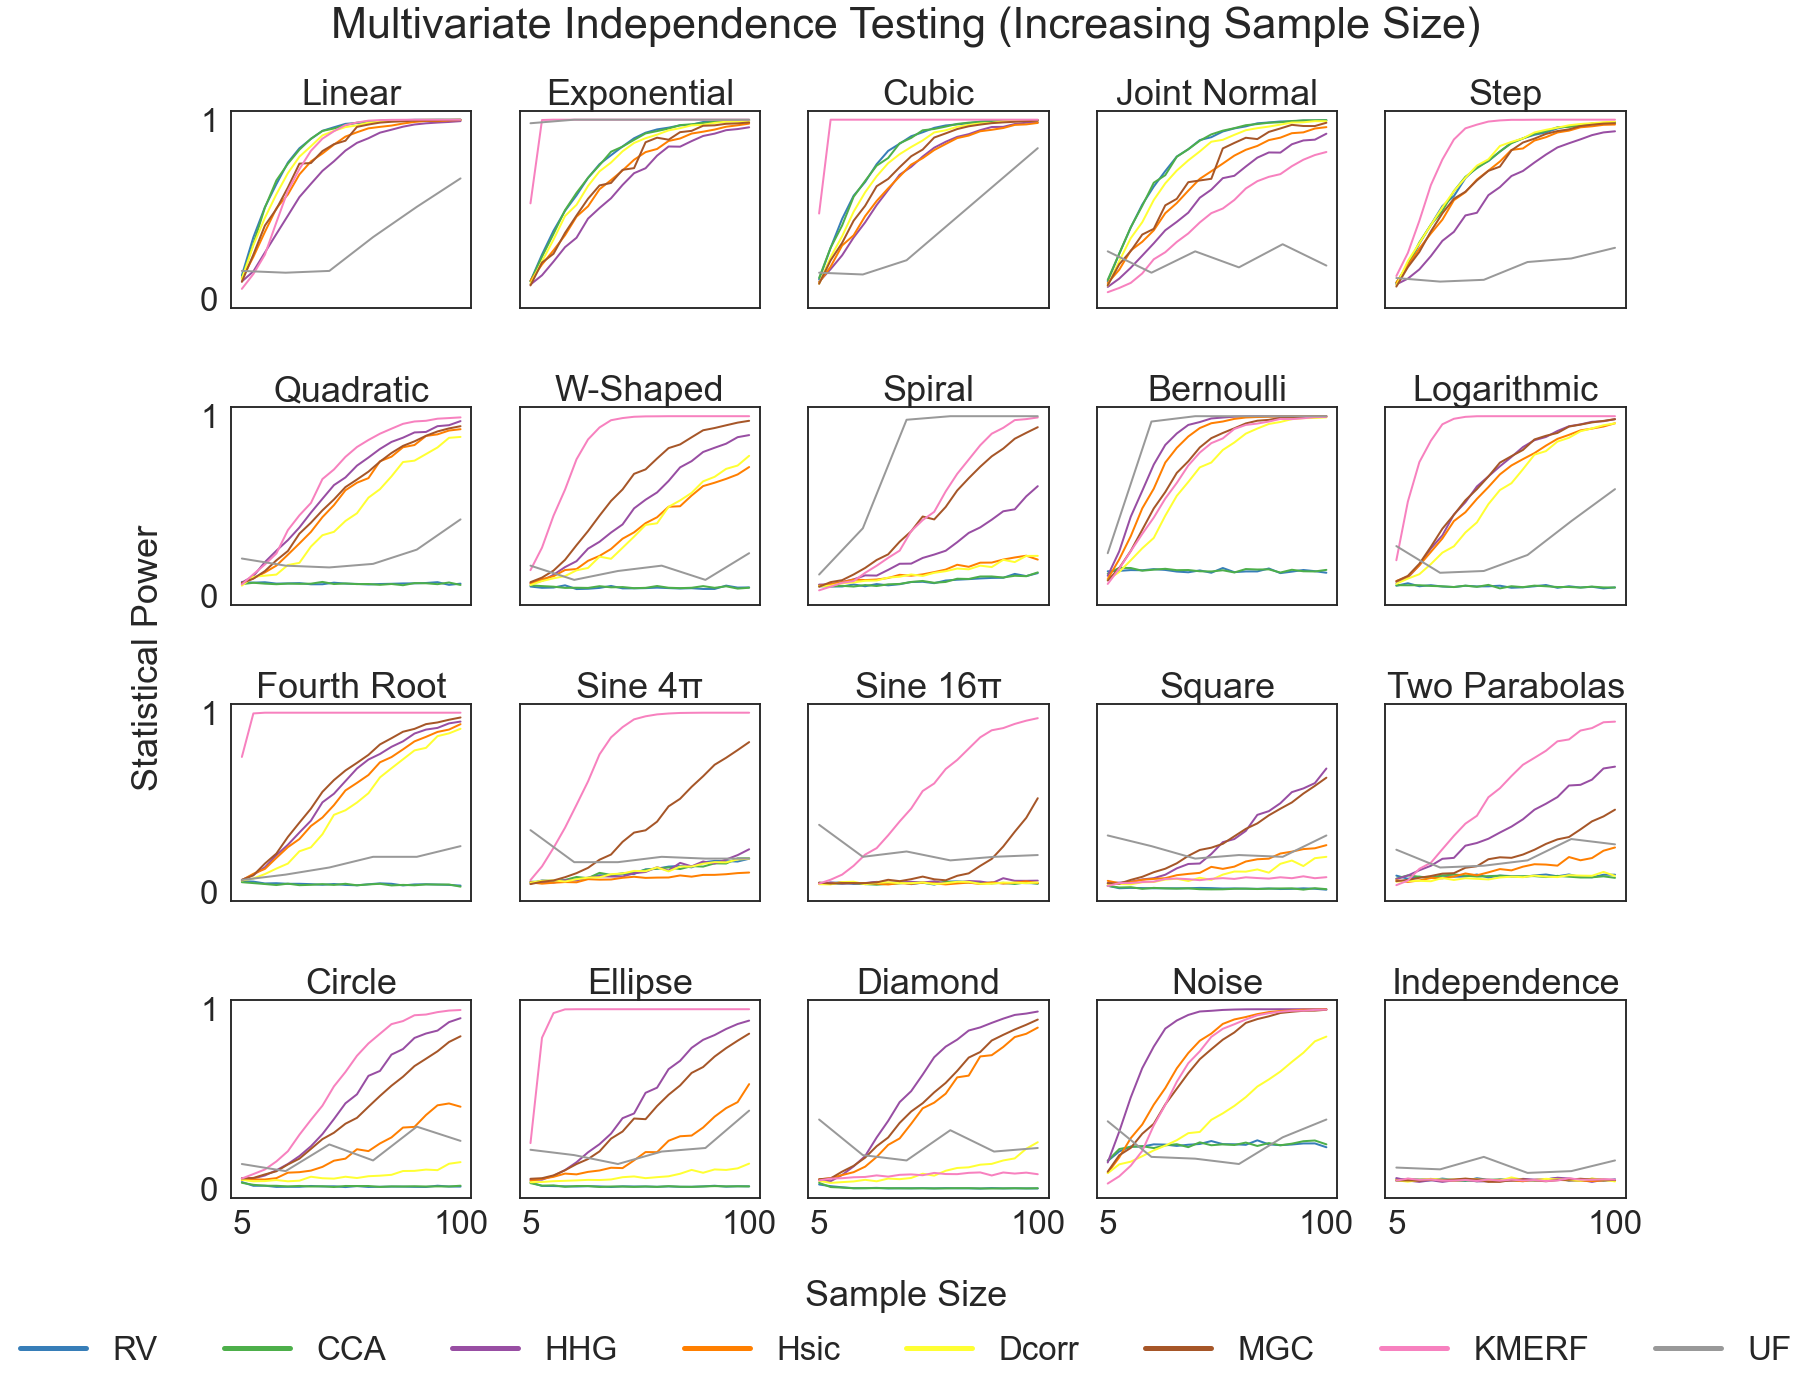

In [29]:
plot_power_all()